In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras
import tensorflow as tf

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
keras.utils.set_random_seed(seed_value)

(10000, 6)
Index(['subreddit', 'post', 'sent_neg', 'sent_neu', 'sent_pos',
       'sent_compound'],
      dtype='object')


<Axes: xlabel='subreddit', ylabel='count'>

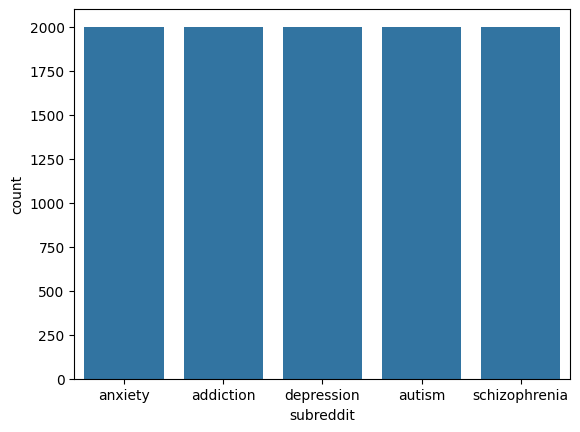

In [2]:
data = pd.read_csv("mental_health_pre+post_pandemic_reddit.csv")
print(data.shape)
print(data.columns)
sns.countplot(data=data, x="subreddit")


In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\derry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\derry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\derry\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
lemma = nltk.WordNetLemmatizer()

In [6]:
def pre_processing(text_data):
    text_list = []
    for text in text_data:
        text = re.sub("[^a-zA-Z]", " ", text).lower()
        words = nltk.word_tokenize(text)
        words = [word for word in words if word not in stopwords.words("english")]
        words = [lemma.lemmatize(word) for word in words]
        text_list.append(" ".join(words))
    return text_list

In [7]:
text_list = pre_processing(data.post)

In [9]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
sparse_matrix = vectorizer.fit_transform(text_list).toarray()

In [10]:
X = np.hstack((sparse_matrix, data.drop(columns=['post', 'subreddit']).to_numpy()))
y = data["subreddit"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [12]:
y_train_onehot = keras.utils.to_categorical(y_train_encoded)
y_test_onehot = keras.utils.to_categorical(y_test_encoded)

x_val_o, x_test_o, y_val_o, y_test_o = train_test_split(x_test, y_test_onehot, test_size=0.5, random_state=42)

# Random Forest

In [13]:
rf = RandomForestClassifier(random_state=seed_value)
rf.fit(x_train, y_train_encoded)

RandomForestClassifier(random_state=42)

In [14]:
def evaluate_model(model, x_train, y_train, x_test, y_test, title):
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    
    print(f'{title} Train Accuracy: {accuracy_score(y_train, train_pred)}')
    print(f'{title} Test Accuracy: {accuracy_score(y_test, test_pred)}')
    print(f'Test Precision: {precision_score(y_test, test_pred, average="weighted")}')
    print(f'Test Recall: {recall_score(y_test, test_pred, average="weighted")}')
    print(f'Test F1-Score: {f1_score(y_test, test_pred, average="weighted")}')
    print(f'Mean Squared Error: {mean_squared_error(y_test, test_pred)}')

    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {title}')
    plt.show()

Random Forest Train Accuracy: 1.0
Random Forest Test Accuracy: 0.7948
Test Precision: 0.80273012375949
Test Recall: 0.7948
Test F1-Score: 0.7969216264543889
Mean Squared Error: 0.9504


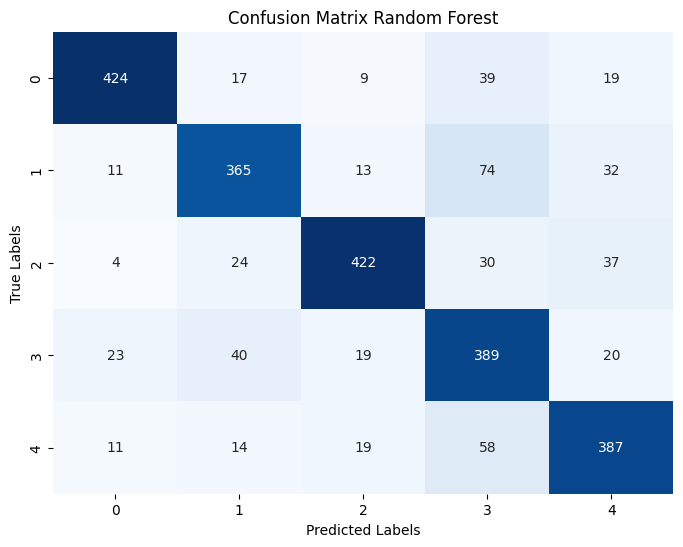

In [15]:
evaluate_model(rf, x_train, y_train_encoded, x_test, y_test_encoded, "Random Forest")

# K-Nearest Neighbors

KNN Train Accuracy: 0.7581333333333333
KNN Test Accuracy: 0.6308
Test Precision: 0.6395461470219633
Test Recall: 0.6308
Test F1-Score: 0.6309218745133076
Mean Squared Error: 1.7496


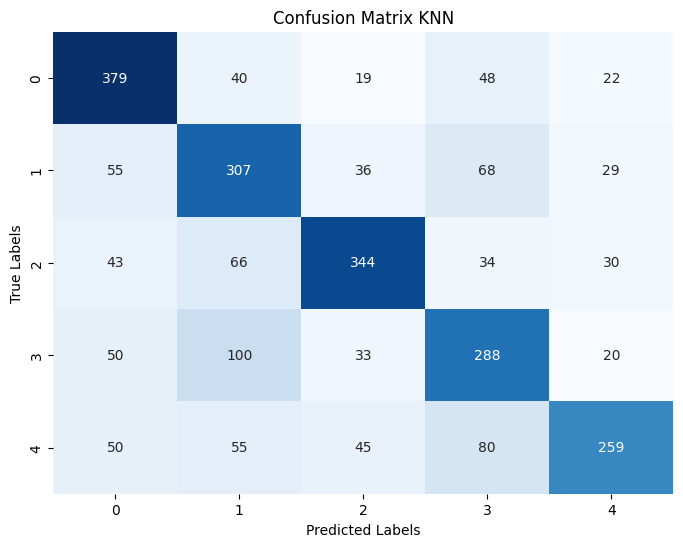

In [16]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train_encoded)
evaluate_model(knn, x_train, y_train_encoded, x_test, y_test_encoded, "KNN")

# Artificial Neural Network

In [17]:
nn = Sequential([
    Dense(256, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])


c:\Users\derry\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
nn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanSquaredError(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
history = nn.fit(
    x_train, y_train_onehot, 
    validation_data=(x_val_o, y_val_o),
    epochs=50, batch_size=32, 
    verbose=1, callbacks=[early_stopping]
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2185 - auc: 0.5164 - loss: 8.9933 - mean_squared_error: 0.1980 - precision: 0.2266 - recall: 0.1156 - val_accuracy: 0.2152 - val_auc: 0.5467 - val_loss: 7.1638 - val_mean_squared_error: 0.1606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2601 - auc: 0.5768 - loss: 6.9264 - mean_squared_error: 0.1682 - precision: 0.3209 - recall: 0.0690 - val_accuracy: 0.3680 - val_auc: 0.6390 - val_loss: 5.7110 - val_mean_squared_error: 0.1529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3850 - auc: 0.7112 - loss: 5.2807 - mean_squared_error: 0.1435 - precision: 0.5981 - recall: 0.1313 - val_accuracy: 0.6816 - val_auc: 0.9108 - val_loss: 3.9980 - val_mean_squared_error: 0.1035 - val_precision: 0.9529 - val_recall: 0.2752
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6

In [21]:
def plot_history(history, metric, val_metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title(f'Model {metric}')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

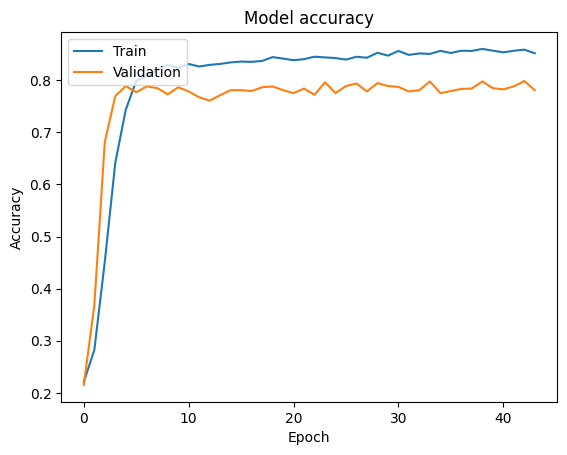

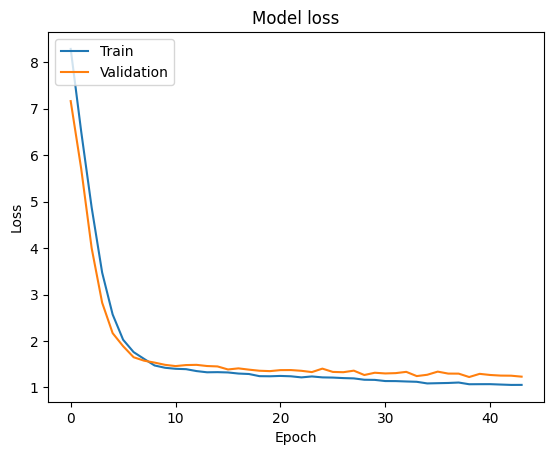

In [22]:
plot_history(history, 'accuracy', 'val_accuracy')
plot_history(history, 'loss', 'val_loss')

In [23]:
test_pred = np.argmax(nn.predict(x_test_o), axis=1)
test_res = np.argmax(y_test_o, axis=1)
cm = confusion_matrix(test_res, test_pred)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


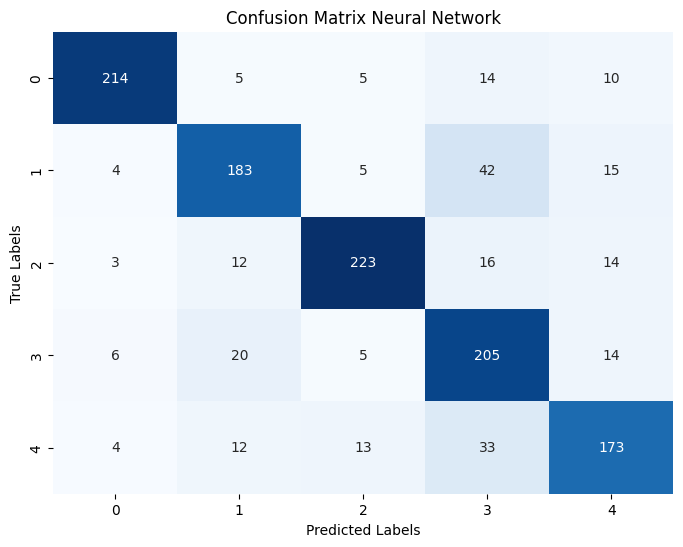

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Neural Network')
plt.show()
